In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sympy import symbols, Eq, solve
from datetime import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy.optimize import minimize, Bounds, show_options, basinhopping, brute, differential_evolution, dual_annealing
import math


# Creating Dataframe

We are just builidng our original dataframe here with date, price, interest, and price changes

In [4]:
excel_file_path = 'chapt26.xlsx'
interest = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,H')
interest = interest.iloc[7:]
interest.columns = ['Year', 'Interest']
interest = interest.reset_index(drop=True)

In [5]:
excel_file_path = 'monthly_data.xls'
df = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,J')
df = df.iloc[7:]
df = df.reset_index(drop=True)
df.columns = ['Date', 'Price']

def correct_date_string_specific(date_str):
    parts = str(date_str).split('.')
    if len(parts) == 2 and parts[1] == '1':
        parts[1] = '10'
    return '.'.join(parts)

df['Date'] = df['Date'].apply(correct_date_string_specific)
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m')
df['Year'] = df['Date'].dt.year

In [6]:
df = pd.merge(interest, df, on = "Year")
df["Interest"] = (df["Interest"] - 1)/12
df = df[["Date", "Price", "Interest"]]

def add_percent_change (df):
    df = df.copy()
    diff = df['Price'].pct_change(fill_method=None)
    df["Percent Change"] = diff
    return df

df = add_percent_change(df)
df.head()

,Date,Price,Interest,Percent Change
0,1871-01-01,109.050018,0.003959,NaN
1,1871-02-01,107.765291,0.003959,-0.011781
2,1871-03-01,109.298845,0.003959,0.01423
3,1871-04-01,117.171191,0.003959,0.072026
4,1871-05-01,123.479273,0.003959,0.053836


# DataFrame Functions

In [7]:
def filter_dataframe_by_date (df, start_date=datetime(1500, 1, 1), end_date=datetime(9999, 1, 1)):
    
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    filtered_df.head()

    return filtered_df.reset_index(drop=True)

def compare_growth_of_diff_leverages (df, start_amount, contributions=5000):
    df.loc[0, "Total Normal Amount"] = start_amount
    df.loc[0, "Total 3x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2.5x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2x Leveraged Amount"] = start_amount
    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"]
        interest_change  = df.loc[i, "Interest"]
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions
        df.loc[i, 'Total 3x Leveraged Amount'] = df.loc[i - 1, 'Total 3x Leveraged Amount'] * (1 + ((3 * percent_change) - (2 * interest_change))) + contributions
        df.loc[i, 'Total 2.5x Leveraged Amount'] = df.loc[i - 1, 'Total 2.5x Leveraged Amount'] * (1 + ((2.5 * percent_change) - (1.5 * interest_change))) + contributions
        df.loc[i, 'Total 2x Leveraged Amount'] = df.loc[i - 1, 'Total 2x Leveraged Amount'] * (1 + ((2 * percent_change) - (1 * interest_change))) + contributions
    return df


# Math Functions

In [8]:

def market_drop(leveraged_x, new_leveraged_x):
    amount = 10000.
    leveraged_amount = amount * leveraged_x

    x = symbols('x')
    equation = Eq((leveraged_amount - x) / (amount - x), new_leveraged_x)
    total_amount_drop = solve(equation, x)[0]
    return total_amount_drop / amount


def calculate_diff_leverages_growth(df, month_interval=6, startamount=10000, contributions=5000):
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1906, 1, 1)

    normal_end_amounts = []
    leveraged3x_end_amounts = []
    leveraged25x_end_amounts = []
    leveraged2x_end_amounts = []
    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df = compare_growth_of_diff_leverages(new_df, startamount, contributions)

        normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
        leveraged3x_end_amount = new_df["Total 3x Leveraged Amount"].iloc[-1]
        leveraged25x_end_amount = new_df["Total 2.5x Leveraged Amount"].iloc[-1]
        leveraged2x_end_amount = new_df["Total 2x Leveraged Amount"].iloc[-1]

        normal_end_amounts.append(normal_end_amount)
        leveraged3x_end_amounts.append(leveraged3x_end_amount)
        leveraged25x_end_amounts.append(leveraged25x_end_amount)
        leveraged2x_end_amounts.append(leveraged2x_end_amount)


        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return normal_end_amounts, leveraged3x_end_amounts, leveraged25x_end_amounts, leveraged2x_end_amounts
    

In [9]:
# price_diff = filter_dataframe_by_date(df, datetime(1871, 2, 1), datetime(1901, 2, 1))
# price_diff = compare_growth_of_diff_leverages(price_diff, 10000.)
# price_diff.tail()

In [10]:
# normal_list, leverage3x_list, leverage25x_list, leverage2x_list  = calculate_diff_leverages_growth(df, 6, 10000)

In [11]:
# s_normal = pd.Series(normal_list)
# s_leverage3x = pd.Series(leverage3x_list)
# s_leverage25x = pd.Series(leverage25x_list)
# s_leverage2x = pd.Series(leverage2x_list)
# print(s_normal.describe())
# print(s_leverage3x.describe())

In [12]:
# # Plotting side-by-side boxplots
# plt.figure(figsize=(8, 16))
# plt.boxplot([s_normal, s_leverage3x, s_leverage25x, s_leverage2x], positions=[1, 2, 3, 4], showfliers=False)
# plt.yscale('log')  # Using a logarithmic scale
# plt.xticks([1, 2, 3, 4], ['Normal 1', '3x', '2.5x', '2x'])
# plt.title('Comparison of Datasets')
# plt.ylabel('Value (log scale)')
# plt.show()

## List of Possible Glidepath Functions

In [13]:
def sigmoid_glide_path(amount):
    max_amount = 10000000
    steepness = 0.0000015
    # The logistic sigmoid function scaled to range from 1 to 3
    sigmoid = 1 / (1 + np.exp(-steepness * (amount - max_amount / 2)))
    return 5 - 4 * sigmoid

def linear_glide_path(amount, start_value=5, end_value=1, max_amount=10000000):
    if (amount > max_amount):
        return 1
    slope = (end_value - start_value) / max_amount
    return start_value + slope * amount

def other_glide_path (amount):
    amount = amount/1000000
    if amount < 2:
        return 5
    elif 2 <= amount <= 10:  # Adjusted curve to start from glide path of 5
        # Using a logarithmic curve for a smoother transition from 5
        return 5 - 4 * np.log10(1 + amount - 2) / np.log10(9)
    else:
        return 1
    
def other2_glide_path (amount):
    lev = 4000000/(amount+1)
    return max(1, min(3, lev+.3))

def constant_leverage (amount, lev=3):
    return lev


## Graph of our manual Path Function

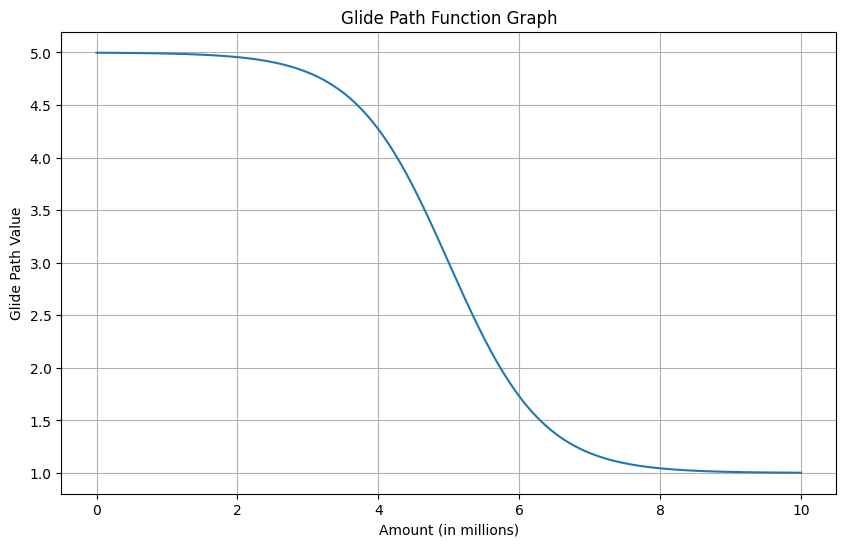

In [14]:
amounts = np.linspace(0, 10000000, 1000)  # From 0 to 8,000,000
glide_path_values = [sigmoid_glide_path(amount) for amount in amounts]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(amounts, glide_path_values, label='Glide Path')

scale_factor = 1e6
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_factor))
plt.gca().xaxis.set_major_formatter(ticks)
plt.title('Glide Path Function Graph')
plt.xlabel('Amount (in millions)')
plt.ylabel('Glide Path Value')
plt.grid(True)
plt.show()

### Defalt Values Set Here

In [15]:
default_start_amount = 10000
default_contribution_amount = 5000
default_month_interval = 12 * 2.5
default_difference = .001

In [16]:
def calculate_growth_with_glide_path (df, list_of_glide_path_func, start_amount=default_start_amount, contributions=default_contribution_amount,):
    df.loc[0, "Total Normal Amount"] = start_amount
    leverage_amount_str =  "Total Leveraged Amount "
    for i in range(0, len(list_of_glide_path_func)):
        t = leverage_amount_str + str(i)
        df.loc[0, t] = start_amount

    first_occur_arr = [0 for _ in range(len(list_of_glide_path_func))]
    happ = [False for _ in range(len(list_of_glide_path_func))]
    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"] - default_difference
        interest_change  = df.loc[i, "Interest"]
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions


        for x, glide_path_func in enumerate(list_of_glide_path_func):
            t = leverage_amount_str + str(x)
            prev_amount = df.loc[i - 1, t]
            glide_path = glide_path_func(prev_amount)
            df.loc[i, t] = max(1, prev_amount * (1 + ((glide_path * percent_change) - ((glide_path - 1) * interest_change))) + contributions)
            if (not happ[x] and df.loc[i, t] > 5000000):
                first_occur_arr[x] = i
                happ[x] = True

    
    return df, first_occur_arr

def calculate_all_amounts_with_glide_paths(df, list_of_glide_path_func, month_interval=default_month_interval, start_amount=default_start_amount, contributions=default_contribution_amount):
    # 30 year time period
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1901, 1, 1)

    array_of_amounts = []
    for _ in range(len(list_of_glide_path_func) + 1):
        array_of_amounts.append([])

    months_arr = []
    for _ in range(len(list_of_glide_path_func) ):
        months_arr.append([])

    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df, index_of_months = calculate_growth_with_glide_path(new_df, list_of_glide_path_func, start_amount, contributions)

        for i in range(0, len(list_of_glide_path_func) + 1):
            if (i == 0):
                normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
                array_of_amounts[i].append(normal_end_amount)
            else :
                leverage_amount_str =  "Total Leveraged Amount "
                temp_str = leverage_amount_str + str(i - 1)
                array_of_amounts[i].append(max(1, new_df[temp_str].iloc[-1]))

        for index, value in enumerate(index_of_months):
            months_arr[index].append(value)
    
        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return months_arr, array_of_amounts


# Visualize the 30-year growth periods to see how volatile  
def visualize(df, list_of_glide_path_func, month_interval=default_month_interval, start_amount=default_start_amount, contributions=default_contribution_amount):
    # 30 year time period
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1901, 1, 1)

    single_df = pd.DataFrame()
    idx = 0
    happ = True
    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df, index_of_months = calculate_growth_with_glide_path(new_df, list_of_glide_path_func, start_amount, contributions)

        if (happ & idx < 40):
            single_df[f"Line {idx + 1}"] = new_df[["Total Leveraged Amount 0"]]
            idx = idx + 1

        happ = not happ
    
        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return single_df

# Attempt to maximize glidepath function return

### Helper functions to help calculate cohort end values

In [17]:
def calculate_growth_with_glide_path_opt (df, glide_func, start_amount=default_start_amount, contributions=default_contribution_amount):
    df.loc[0, "Total Leveraged Amount"] = start_amount

    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"] - default_difference
        interest_change  = df.loc[i, "Interest"]

        prev_amount = df.loc[i - 1, "Total Leveraged Amount"]
        glide_path = glide_func(prev_amount)
        df.loc[i, 'Total Leveraged Amount'] = max(1, prev_amount * (1 + ((glide_path * percent_change) - ((glide_path - 1) * interest_change))) + contributions)

    
    return df

def calculate_amount_with_glide_path_opt(df, glide_func, month_interval=default_month_interval, start_amount=default_start_amount, contributions=default_contribution_amount):
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1901, 1, 1)

    leverage_amount = []

    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df = calculate_growth_with_glide_path_opt(new_df, glide_func, start_amount, contributions)

        leverage_amount.append(max(1, new_df['Total Leveraged Amount'].iloc[-1]))
    
        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    #print(end_date)
    return np.array(leverage_amount)

### Glide Path functions that we want to optimize

In [18]:
sigmoid_temp = [7.61645333e+00, 1.42234210e-06, 8.68306690e+06, 6.21570943e-01]
piecewise_temp = [-2.17423293e-07,  8.38021564e+00, -4.05258433e-06, 6.39217193e+00, -9.82229827e-06, 
                  9.32770644e+00, -1.10854224e-07,  2.22762317e+00, 
                  4.96697812e+06,  2.43985089e+06,  1.83686376e+06]

max_lev = 9
min_lev = 0.1

def sigmoid(amount, arr):
    amplitude, steepness, hort_shift, lower_bound = arr
    exp_input = steepness * (amount - hort_shift)
    safe_exp_input = np.clip(exp_input, None, 700)
    return min(max_lev, lower_bound + (amplitude / (1 + np.exp(safe_exp_input))))

def sigmoid_default(amount, arr=sigmoid_temp):
    amplitude, steepness, hort_shift, lower_bound = arr
    exp_input = steepness * (amount - hort_shift)
    safe_exp_input = np.clip(exp_input, None, 700)
    return min(max_lev, lower_bound + (amplitude / (1 + np.exp(safe_exp_input))))

def piecewise (amount, arr):
        slope_1, y_1, slope_2, y_2, slope_3, y_3, slope_4, y_4, x1, x2, x3 = arr
        if (amount < x1):
            return slope_1 * amount + y_1
        elif (amount >= x1 and amount < x2):
            return slope_2 * amount + y_2
        elif (amount >= x2 and amount < x3):
            return slope_3 * amount + y_3
        elif (amount >= x3):
            return slope_4 * amount + y_4
        
def piecewise_default (amount, arr=piecewise_temp):
        slope_1, y_1, slope_2, y_2, slope_3, y_3, slope_4, y_4, x1, x2, x3 = arr
        if (amount < x1):
            return min(max_lev, max(min_lev, slope_1 * amount + y_1))
        elif (amount >= x1 and amount < x2):
            return min(max_lev, max(min_lev, slope_2 * amount + y_2))
        elif (amount >= x2 and amount < x3):
            return min(max_lev, max(min_lev, slope_3 * amount + y_3))
        elif (amount >= x3):
            return min(max_lev, max(min_lev, slope_4 * amount + y_4))
        
def polynomial (amount, arr):
     five, four, three, two, one, hort_shift = arr
     amount = (amount / 1e6) - hort_shift
     res = five * amount**5 + four * amount**4 + three * amount**3 + two * amount**2 + one * amount**1
     return np.clip(res, min_lev, max_lev)
        


In [22]:
def calc_quartile_avg (passed_list, log=True):
    if (log):
        passed_list = np.log10(passed_list)
    weight_quartile_1 = 0.4
    weight_quartile_2 = 0.3
    weight_quartile_3 = 0.2
    weight_quartile_4 = 0.1
    weight_quartile_5 = 0

    percentile_20 = np.percentile(passed_list, 20)
    percentile_40 = np.percentile(passed_list, 40)
    percentile_60 = np.percentile(passed_list, 60)
    percentile_80 = np.percentile(passed_list, 80)

    quartile_1 = np.mean(passed_list[passed_list < percentile_20])
    quartile_2 = np.mean(passed_list[(passed_list >= percentile_20) & (passed_list < percentile_40)])
    quartile_3 = np.mean(passed_list[(passed_list >= percentile_40) & (passed_list < percentile_60)])
    quartile_4 = np.mean(passed_list[(passed_list >= percentile_60) & (passed_list < percentile_80)])
    quartile_5 = np.mean(passed_list[passed_list >= percentile_80])
    avg = weight_quartile_1 * quartile_1 + weight_quartile_2 * quartile_2 + weight_quartile_3 * quartile_3 + weight_quartile_4 * quartile_4 + weight_quartile_5 * quartile_5

    return avg


def optimize(list_of_var, func):
    def helper (amount):
        return func(amount, list_of_var)
    
    leverage_list_opt = calculate_amount_with_glide_path_opt(df, helper)
    avg = calc_quartile_avg(leverage_list_opt)
    

    result = -1. * avg
    #print(result)
    return result

def sigmoid_optimize(list_of_var):
    return optimize(list_of_var, sigmoid)

def piecewise_optimize(list_of_var):
    return optimize(list_of_var, piecewise)

def polynomial_optimize(list_of_var):
    return optimize(list_of_var, polynomial)

guess_sigmoid = [7.52701453e+00, 2.08417665e-06, 6.22858109e+06, 6.72461394e-01]
guess_piecewise = [-1e-6, 5 , -1e-6, 4.8, -1e-6, 4, -1e-6, 3]


bound_sigmoid = [
    (0.0, 9),
    (2e-07, 1e-05),
    (-5e+06, 10e+06),
    (0, 1.2)
]
bound_piecewise =[
    (-1e-5, -1e-8),
    (0, 8),
    (-1e-5, -1e-8),
    (0, 8),
    (-1e-5, -1e-8),
    (0, 8),
    (-1e-5, -1e-8),
    (0, 8),
    (0, 5e6),
    (0, 5e6),
    (0, 7e6),
]
bound_polynomial = [
    (-10, 10),
    (-10, 10),
    (-10, 10),
    (-10, 10),
    (-10, 10),
    (-5, 5),
]

In [20]:
# Check if initial guess is within bounds
# if not all(lower <= x <= upper for x, (lower, upper) in zip(guess_piecewise, bound_piecewise)):
#     print ("Initial guess is not within the specified bounds")
# show_options(solver='minimize', method='COBYLA', disp=True)

In [23]:
#accept is not per step, it is per iteration (per local minima)
def accept(**kwargs):
    xnew = kwargs['x_new']
    print("test")
    for xi, (low, high) in zip(xnew, bound_piecewise):
        if not (low <= xi <= high):
            return False
    return True

result = differential_evolution(sigmoid_optimize, bound_sigmoid, disp=True) #need to try dual annuel

#piecewise_minimizer_kwargs = { "method": "Nelder-Mead","bounds":bound_piecewise }
#basinhopping(piecewise_optimize, guess_piecewise, T=2, accept_test=accept, minimizer_kwargs=piecewise_minimizer_kwargs, disp=True, niter_success=1)

differential_evolution step 1: f(x)= -6.9854
differential_evolution step 2: f(x)= -7.00543
differential_evolution step 3: f(x)= -7.00543
differential_evolution step 4: f(x)= -7.00543
differential_evolution step 5: f(x)= -7.04108
differential_evolution step 6: f(x)= -7.04108
differential_evolution step 7: f(x)= -7.04108
differential_evolution step 8: f(x)= -7.04108
differential_evolution step 9: f(x)= -7.04108
differential_evolution step 10: f(x)= -7.04529
differential_evolution step 11: f(x)= -7.04877
differential_evolution step 12: f(x)= -7.05198
differential_evolution step 13: f(x)= -7.05261
Polishing solution with 'L-BFGS-B'


In [24]:
print(result.x)
print(result.fun)
print(result.success)
print(result.message)

temp_opt = [x for x in result.x]
print(len(temp_opt))

[8.95681337e+00 1.52215659e-06 5.09359033e+06 8.13207557e-01]
-7.0552869521824375
True
Optimization terminated successfully.
4


## Guesses

1. [7.61645333e+00 1.42234210e-06 8.68306690e+06 6.21570943e-01] => -7.236472384747586

    This is for sigmoid_opt of default_start_amount = 10000, default_contribution_amount = 5000, default_month_interval = 12 * 2.5, default_difference = .000

2. [-2.97517529e-06  8.04051349e+00 -1.01686877e-06  8.72164523e+00 -7.45196808e-07  9.53897600e+00 -4.31036545e-06  8.00850297e+00] => -7.087004155096324

    This is for piecewise of default_start_amount = 10000, default_contribution_amount = 5000, default_month_interval = 12 * 2.5, default_difference = .000 with set x values

3. [-2.17423293e-07  8.38021564e+00 -4.05258433e-06  6.39217193e+00 -9.82229827e-06  9.32770644e+00 -1.10854224e-07  2.22762317e+00 4.96697812e+06  2.43985089e+06  1.83686376e+06] => -7.111982124971696

    This is for piecewise of default_start_amount = 10000, default_contribution_amount = 5000, default_month_interval = 12 * 2.5, default_difference = .000 with varying x values.

4. [-5.25354450e-08  8.36252777e+00 -1.59055917e-06  5.37105628e+00
 -3.33447881e-06  3.21115594e+00 -2.16527293e-07  3.54469172e+00
  4.48643019e+06  2.93376744e+06  2.47906832e+06  6.80476220e-01
  7.94358320e+00]
-7.16883075317587

5. [-1.52220080e-07  8.46270441e+00 -3.10300019e-06  6.63992385e+00
 -2.47083369e-06  3.19308924e+00 -8.11634160e-07  9.79006055e+00
  3.53446409e+06  2.33426388e+06  3.39381660e+06  8.26682453e-01
  7.83147076e+00]
-7.199014790128642

6. [7.79498742e+00 6.78299963e-06 7.59723102e+06 1.09826310e+00]
-7.315850902854188

7. [-3.58192185e-07  7.50307722e+00 -3.90285116e-06  3.33148209e+00
 -6.86964144e-06  6.22891024e-01 -6.07844579e-08  2.68487418e+00
  4.20075564e+06  4.68437616e+06  8.40069262e+05]
-7.173083995208977 

    This is unbounded piecewise, it goes into negative leverage which is a problem. Current problem is that if we (min max) the bounds of the leverage function, i am not sure if this correctly utilizing the optimize func because any paramters that exceed the bounds of lev func will result in the same value.


8. [-0.4716598   6.87965871 -2.85194484  7.62151847  0.63390778  4.38047322]
-7.420124470290059

    This is polynomial that achieved a negative value somehow


9. [8.99967086e+00 3.03509188e-06 5.02974074e+06 8.89664075e-01]
-7.061722612608467

    This is dual annualeing for sigmoid.
    


In [25]:
# temp_opt = [-0.4716598,   6.87965871, -2.85194484,  7.62151847,  0.63390778, 4.38047322]

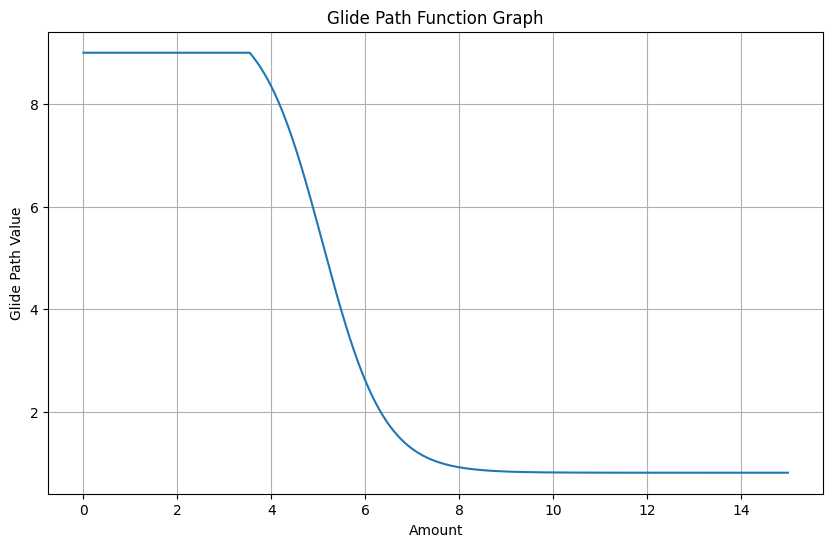

In [26]:
amounts = np.linspace(0, 15000000, 1000)  # From 0 to 8,000,000
glide_path_values = [sigmoid(amount, temp_opt) for amount in amounts]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(amounts, glide_path_values, label='Glide Path')

plt.gca().xaxis.set_major_formatter(ticks)
plt.title('Glide Path Function Graph')
plt.xlabel('Amount')
plt.ylabel('Glide Path Value')
plt.grid(True)
plt.show()

## Visualize growth graph for each 30-year period


In [ ]:
single_list = [lambda x: polynomial(x, temp_opt)]
visualize_df = visualize(df, single_list)

In [ ]:
# Plot each column with an offset
plt.figure(figsize=(10, 6))
offset_value = 1  # Define the offset value
for column in visualize_df.columns:
    plt.plot(visualize_df.index, visualize_df[column], label=column)

plt.xlabel('Index')
plt.ylabel('Value')
plt.yscale('log')
plt.title('Glide Path Proof')
plt.legend()
plt.show()

# Collecting data on multiple glide paths

In [27]:
list_of_glide_path_func = [piecewise_default, sigmoid_default, lambda x: sigmoid(x, temp_opt), constant_leverage]
months_list, leverage_list = calculate_all_amounts_with_glide_paths(df, list_of_glide_path_func)

2026-01-01 00:00:00


In [29]:
s = pd.Series(calculate_amount_with_glide_path_opt(df, lambda x: sigmoid(x, temp_opt)))
s.describe()

count    5.000000e+01
mean     2.132620e+07
std      1.141971e+07
min      8.075320e+05
25%      1.142672e+07
50%      2.164024e+07
75%      2.954890e+07
max      4.790522e+07
dtype: float64

In [30]:
series_list = [pd.Series(inner_list) for inner_list in leverage_list]
# for list in series_list:
#     print(list.describe())

3755480.7104594586
9982173.177794665
14241765.854355834
13804108.52923856
3781762.684936422


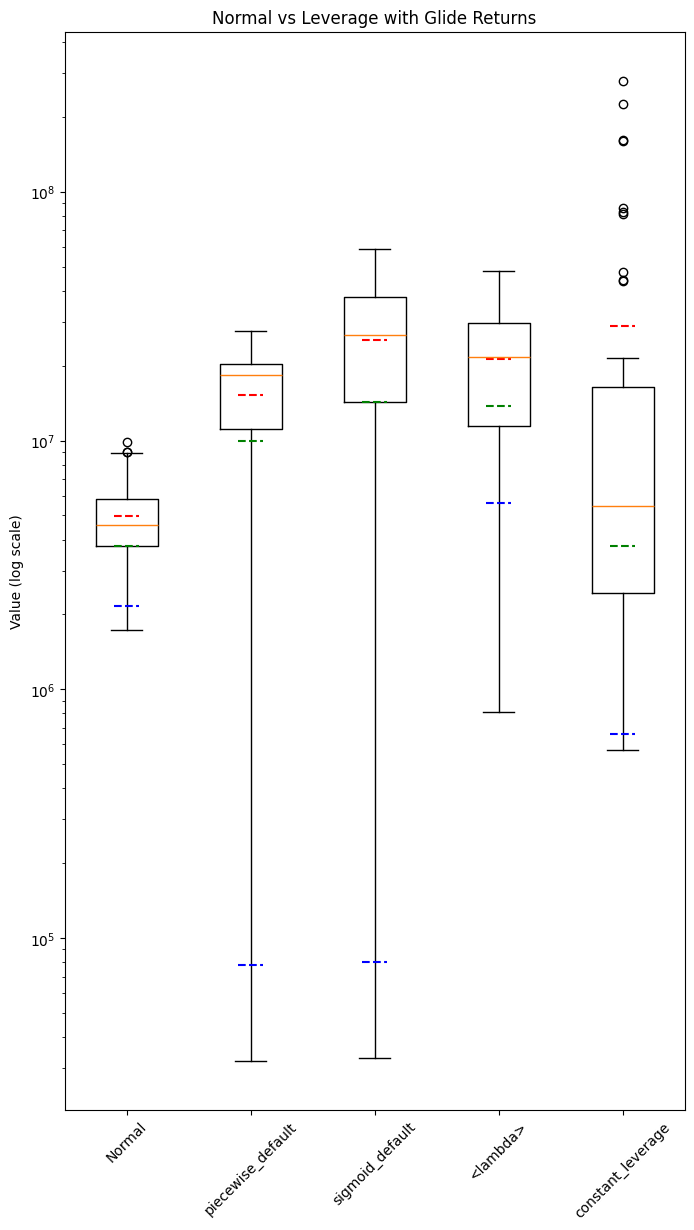

In [31]:
# Plotting side-by-side boxplots
plt.figure(figsize=(8, 14))
plt.boxplot(series_list, positions=[i for i in range(1,len(series_list) + 1)], showfliers=True)

# Calculate the xth percentile for each dataset
xth_perc = 2
for i, series in enumerate(series_list):
    percentile = np.percentile(series, xth_perc)
    mean_mark = np.mean(series)
    avg = calc_quartile_avg(series, False)
    print(avg)
    plt.hlines(percentile, i + 0.9, i + 1.1, linestyles='dashed', color='blue')
    plt.hlines(mean_mark, i + 0.9, i + 1.1, linestyles='dashed', color='red')
    plt.hlines(avg, i + 0.9, i + 1.1, linestyles='dashed', color='green')


 # Create custom legend handles
# percentile_line = mlines.Line2D([], [], color='blue', linestyle='dashed', label=f'{xth_perc}th Percentile')
# mean_line = mlines.Line2D([], [], color='red', linestyle='dashed', label='Mean')

# Add the legend to the plot
# plt.legend(handles=[percentile_line, mean_line])


plt.yscale('log')  # Using a logarithmic scale
func_names = []
func_names.append
plt.xticks([i for i in range(1,len(series_list) + 1)], ["Normal"] + [func.__name__ for func in list_of_glide_path_func])
plt.xticks(rotation=45)
plt.title('Normal vs Leverage with Glide Returns')
plt.ylabel('Value (log scale)')
plt.show()

# Visulaize distrubution of months across glidepath functions

In [ ]:
series_months_list = [pd.Series(inner_list) for inner_list in months_list]
# for list in series_months_list:
#     print(list.describe())

In [ ]:
# plt.figure(figsize=(8, 12))
# plt.boxplot([series_months_list], positions=[1], showfliers=False)
# percentile_month = np.percentile(series_months_list, 90)
# plt.hlines(percentile_month, 0.9, 1.1, colors='blue', linestyles='dashed')
# plt.xticks([1], ['Months'])
# plt.title('Month Distribution')
# plt.ylabel('# of months')
# plt.show()


# Plotting side-by-side boxplots
plt.figure(figsize=(8, 12))
plt.boxplot(series_months_list, positions=[i for i in range(1,len(series_months_list) + 1)], showfliers=False)

# Calculate the xth percentile for each dataset
xth_perc = 98
for i, series in enumerate(series_months_list):
    percentile = np.percentile(series, xth_perc)
    plt.hlines(percentile, i + 0.9, i + 1.1, linestyles='dashed')

func_names = []
func_names.append
plt.xticks([i for i in range(1,len(series_months_list) + 1)], [func.__name__ for func in list_of_glide_path_func])
plt.xticks(rotation=45)
plt.title('Distrubtion of months till launch')
plt.ylabel('# of months till passed half mark')
plt.show()